# Find peaks of DRT
This python code is used for investigating the peaks of a DRT function by means of fitting with Gaussian function, the default number of Gaussian function is 3.
1. read DRT file (the x-axis will transfer through log10)
2. fitting with Gaussian functions
 这一步需要注意spec['Model']里的数目
3. output the characteristic parameters for each Gaussian function

## 1 读取DRT数据

 filenames:  ['27-20.csv', '2700.csv', '2710.csv', '2720.csv', '2730.csv', '2740.csv', '2750.csv', '2760.csv', '2770.csv', '2780.csv', '2790.csv', '279100.csv', '279110.csv'] 

 len(filenames): 13

 filename:  279110.csv


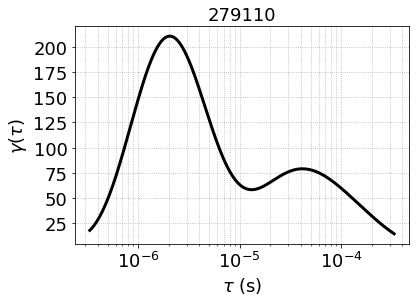

In [543]:
# !/usr/bin python3
# Fukun Shi, 2019.04.22
# https://chrisostrouchov.com/post/peak_fit_xrd_python/
'''
基于最小二乘lmfit做multi-peaks分析
'''
import os
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize, signal
from sklearn.metrics import auc

from lmfit import models

%matplotlib inline

#######################
# 1 输入需要拟合的曲线#

fl = 3e3
fh = 3e6
taul = 1/fh
tauh = 1/fl

maindir = 'D:\\Nutstore\\PhD\\Experiment\\EIS_data_transform\\P1_data\\P1DRT'

###############################
fp0 = '26-04-2017'
fp1 = '27 60ns'
fp2 = '27 DRT'
fpgaussian = 'gaussians'
fppeak = 'peaks'
##############################

domain = os.path.join(maindir,fp0,fp1)# 第一步读取文件
filenames = os.listdir(domain)
print(' filenames: ',filenames,'\n\n len(filenames):',len(filenames))

#### num代表要读取的文件###
num = 12
info = os.path.join(domain,filenames[num]) # 读取文件路径
print('\n filename: ', filenames[num])
###############################

filename = filenames[num].strip('.csv')

foutput = os.path.join(maindir,fp0,fp2) #filename + '_Gaussian.xlsx'  # 第二步保存拟合的高斯函数
#filepath1 = maindir + '\\Peaks\\' + filename + '_Peaks.xlsx'     # 第三步输出结果

drt = pd.read_csv(info,header=2)
drt.columns = ['Gamma','tau']
drt = drt.loc[(drt.tau>=taul)&(drt.tau<=tauh)]
drt.reset_index(inplace=True,drop=True)

R_tau = pd.DataFrame(columns=['tau'])
R_tau['tau'] = drt['tau']                    # 保留一份没有对数化的横坐标

drt['t'] = drt['tau']
drt['tau'] = np.log10(drt.tau.values) # 将横坐标化为log10(t)
#print(drt)

plt.semilogx(drt['t'],drt['Gamma'],linewidth=3,color='k')
plt.title(filename,fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('$\\tau$ (s)',fontsize=18)
plt.ylabel('$\gamma(\\tau)$',fontsize=18)
#plt.ylim(0,350)
plt.grid(linestyle=':',which='both')
plt.show()

## 2 用find_peaks_cwt寻找peaks.从上图中人工判断多少个峰

2
End


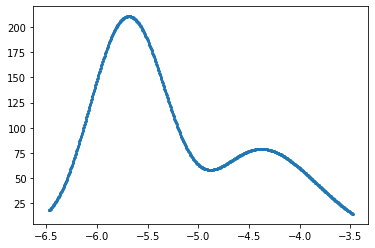

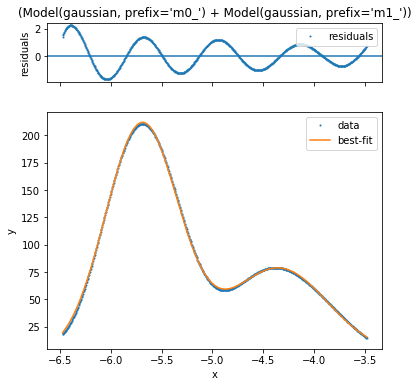

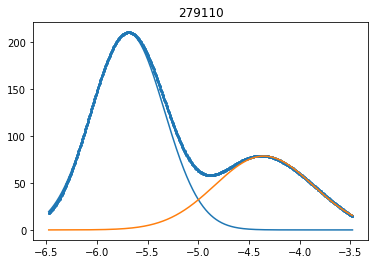

In [545]:
##########################################################################
# 利用lmfit拟合double Gaussian-peaks。先定义parameters，然后用fit函数拟合#
def generate_model(spec):
    '''定义适合使用lmfit拟合的复合函数模型，包括高斯，洛伦茨和福格特函数'''
    composite_model = None
    params = None
    x = spec['x']
    y = spec['y']
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    y_max = np.max(y)
    for i, basis_func in enumerate(spec['model']):              # enumerate序列化输入的list，用于分离序列号和实例值
        prefix = f'm{i}_'                                       # f字符串格式化语法，类似format和%。prefix适用于区分复合函数内的同名参数
        model = getattr(models, basis_func['type'])(prefix=prefix) 
                                                                # models包含了lmfit内建的函数库。getattr用于提取type对应的函数。选定函数
        if basis_func['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']: 
                                                                # for now VoigtModel has gamma constrained to sigma
            model.set_param_hint('sigma', min=1e-6, max=x_range)# 用于make_params，指定参数的尺度和范围
            model.set_param_hint('center', min=x_min, max=x_max)
            model.set_param_hint('height', min=1e-6, max=1.1*y_max)
            model.set_param_hint('amplitude', min=1e-6)
                                                                # default guess is horrible!! do not use guess()。定义默认初始值
            default_params = {                                  # 基于XRD的理解而选定的初始值
                prefix+'center': x_min + x_range * random.random(),
                prefix+'height': y_max * random.random(),
                prefix+'sigma': x_range * random.random()
            }
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
        if 'help' in basis_func:                                # allow override of settings in parameter
            for param, options in basis_func['help'].items():
                model.set_param_hint(param, **options)
        model_params = model.make_params(**default_params, **basis_func.get('params', {})) # 确定参数
        if params is None:
            params = model_params
        else:
            params.update(model_params)
        if composite_model is None:
            composite_model = model
        else:
            composite_model = composite_model + model
    return composite_model, params


def update_spec_from_peaks(spec, model_indicies, peak_widths=(10, 25), **kwargs):
    '''寻找peaks，model_indicies是输入复合函数的索引'''
    x = spec['x']
    y = spec['y']
    x_range = np.max(x) - np.min(x)
    peak_indicies = signal.find_peaks_cwt(y, peak_widths) # 寻找peaks的函数
    np.random.shuffle(peak_indicies)
    for peak_indicie, model_indicie in zip(peak_indicies.tolist(), model_indicies):
        model = spec['model'][model_indicie]
        if model['type'] in ['GaussianModel', 'LorentzianModel', 'VoigtModel']:
            params = {                                    # 参数初始值设定
                'height': y[peak_indicie],
                'sigma': x_range / len(x) * np.min(peak_widths),
                'center': x[peak_indicie]
            }
            if 'params' in model:
                model.update(params)
            else:
                model['params'] = params
        else:
            raise NotImplemented(f'model {basis_func["type"]} not implemented yet')
    return peak_indicies

spec = {
    'x': drt.tau.values,
    'y': drt['Gamma'].values,
    'model': [
        {'type': 'GaussianModel'},
        {'type': 'GaussianModel'},
        #{'type': 'GaussianModel'},  # 这里修改peaks数目
        #{'type': 'GaussianModel'},
    ]
}


peaks_found = update_spec_from_peaks(spec, list(range(len(spec['model']))), peak_widths=(1e-5, 1e-3)) # 找出peaks,list(range(len(spec['model'])))设定peaks数目
fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)                          # x是输入的XRD横坐标，y是纵坐标值
for i in peaks_found:
    ax.axvline(x=spec['x'][i], c='black', linestyle='dotted')  # 画出竖直虚线标出peaks位置。

model, params = generate_model(spec)               # 生成复合函数
output = model.fit(spec['y'], params, x=spec['x']) # 拟合
fig, gridspec = output.plot(data_kws={'markersize':  1})

fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])  # 得到各个拟合函数
                                 
Gau = pd.DataFrame()                              # 得到每个子函数的值
Gau['tau'] = R_tau['tau'] #spec['x']
                                 
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])      # 画出各个复合函数的图
    Gau['m'+str(i)] = components[f'm{i}_']
plt.title(filename)
                                 
if len(spec['model'])==2:
    Gau['Gaussian_sum'] = Gau['m0'] + Gau['m1'] #+ Gau['m2'] #+ Gau['m3']
else:
    Gau['Gaussian_sum'] = Gau['m0'] + Gau['m1'] + Gau['m2']
#Gau.to_excel(filepath0,index=False)               # 保存每个子函数的值到文件中。
print('End')
                                 

## 3 输出最佳拟合结果

In [553]:
#####################

def print_best_values(spec, output):
    model_params = {
        'GaussianModel':   ['amplitude', 'sigma'],
        'LorentzianModel': ['amplitude', 'sigma'],
        'VoigtModel':      ['amplitude', 'sigma', 'gamma']
    }
    best_values = output.best_values
    print('center    model  ： amplitude     sigma      gamma')
    for i, model in enumerate(spec['model']):
        prefix = f'm{i}_'
        values = ', '.join(f'{best_values[prefix+param]:8.3f}' for param in model_params[model["type"]])
        print(f'[{best_values[prefix+"center"]:3.3f}] {model["type"]:16}: {values}')
        
if len(spec['model'])==2:
    Peaks = np.zeros(6).reshape(2,3)
else:
    Peaks = np.zeros(9).reshape(3,3) #pd.DataFrame(columns = ['center','model','amplitude','sigma','gamma'])

for i,model in enumerate(spec['model']):
    prefix = f'm{i}_'
    Peaks[i,0] = output.best_values[prefix+'center']#print(best_values[prefix+'center'])
    #Peaks[i,1] = output.best_values[prefix+'model']
    Peaks[i,1] = output.best_values[prefix+'amplitude']
    Peaks[i,2] = output.best_values[prefix+'sigma']
Peaks = pd.DataFrame(Peaks,columns=['center','amplitude','sigma'])
              
if len(spec['model'])==2:
    Peaks['Model'] = ['Gau1','Gau0']
else:
    Peaks['Model'] = ['Gau1','Gau0','Gau2']

Peaks.set_index(['Model'],inplace=True)
Peaks.sort_values(by=['center'],inplace=True,ascending=False)  
print(' Peaks: \n','检查Gau0，1，2对应的值是否按大小排列了，有错乱的需要调整‘Model’里面的数字 \n',Peaks)
#Peaks.to_excel(filepath1,index=False)
print('\n')
print_best_values(spec, output)
              
area = auc(np.log(Gau['tau']),Gau['m0']) # the area under the peak
print('\n','area under peak 0: ',area)

 Peaks: 
 检查Gau0，1，2对应的值是否按大小排列了，有错乱的需要调整‘Model’里面的数字 
          center   amplitude     sigma
Model                                
Gau0  -4.351676   95.368441  0.483886
Gau1  -5.693166  188.974696  0.358625


center    model  ： amplitude     sigma      gamma
[-5.693] GaussianModel   :  188.975,    0.359
[-4.352] GaussianModel   :   95.368,    0.484

 area under peak 0:  428.78903399413053


## 4 保存结果

In [547]:
fgaussian = os.path.join(foutput,fpgaussian,filename+'_Gaussian.csv')
fpeaks = os.path.join(foutput,fppeak,filename+'_Peak.csv')
Gau.to_csv(fgaussian,index=False)

Peaks.to_csv(fpeaks)

## 结束
后续可调用 Merge_Peaks_for_Comparison.ipynb转换Peaks里参数单位，并且统一成一列表

[ 6.38217608e+02 -3.09793316e+00  8.93670904e-01 -2.51342068e+02
 -3.26301973e+00  3.88247052e-01  2.68462230e+02 -5.55162188e+00
  3.55620716e-01]


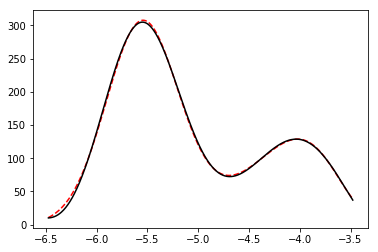

In [26]:
'''利用curve_fit拟合Cole或Gaussian模型。 Cole模型拟合的不好。'''

def Cole(x,tau,alpha):
    '''Cole Function'''
    return 1/2*np.pi*(np.sin(np.pi*alpha)/(np.cosh(alpha*np.log(x/tau))+np.cos(np.pi*alpha)))

def ColeModel(x,tau1,alpha1,tau2,alpha2,tau3,alpha3):
    ColeModel = Cole(x,tau1,alpha1) + Cole(x,tau2,alpha2) + Cole(x,tau3,alpha3)
    return ColeModel

def g(x, A, u, d):
    '''Gaussian function'''
    return A / (d * math.sqrt(2 * math.pi)) * np.exp(-(x-u)**2 / (2*d**2))

def GModel(x,a1,u1,d1,a2,u2,d2,a3,u3,d3):
    GModel = g(x,a1,u1,d1) + g(x,a2,u2,d2) + g(x,a3,u3,d3)
    return GModel

x = drt['tau'].values
y = drt['Gamma'].values

p0 = np.array([12.215,-6.074,0.329,81.385,-3.854,0.374,57.811,-4.861,0.427])#np.array([-4,0.6,-5.5,0.9,-6,0.3]) #
popt,pcov = optimize.curve_fit(GModel,x,y,p0=p0,maxfev=10000,ftol=1e-16)
print(popt)
plt.plot(x,GModel(x,*popt),'r--')
plt.plot(x,y,'k')

In [ ]:
# 3 定义先验params
spec = {
    'x': df.index.values,
    'y': df['count'].values,
    'model': [
        {
            'type': 'GaussianModel',
            'params': {'center': 34.11, 'height': 13.08, 'sigma': 0.1},
            'help': {'center': {'min': 33.5, 'max': 34.5}}
        },
        {
            'type': 'VoigtModel',
            'params': {'center': 36.37, 'height': 30.94, 'sigma': 0.1, 'gamma': 0.1},
            'help': {'center': {'min': 35, 'max': 37}}
        },
        {'type': 'GaussianModel', 'params': {'center': 39.57, 'height': 76.56, 'sigma': 0.1}},
        {
            'type': 'GaussianModel',
            'params': {'center': 40.85, 'height': 30.77, 'sigma': 0.1},
            'help': {'center': {'min': 40, 'max': 42}}
        },
        {'type': 'VoigtModel', 'params': {'center': 41.73, 'height': 38.44, 'sigma': 0.05, 'gamma': 0.15}},
        {
            'type': 'GaussianModel',
            'params': {'center': 42.55, 'height': 45.29, 'sigma': 0.1},
            'help': {'center': {'min': 42, 'max': 43}}
        },
        {'type': 'GaussianModel', 'help': {'center': {'max': 39.2}}},
        #{'type': 'GaussianModel'},
        #{'type': 'GaussianModel'}
    ]
}

model, params = generate_model(spec)
output = model.fit(spec['y'], params, x=spec['x'])
fig, gridspec = output.plot(data_kws={'markersize': 1})

fig, ax = plt.subplots()
ax.scatter(spec['x'], spec['y'], s=4)
components = output.eval_components(x=spec['x'])
print(len(spec['model']))
for i, model in enumerate(spec['model']):
    ax.plot(spec['x'], components[f'm{i}_'])

steps 19 1.0405794663066283
amplitude: 102.876 mean: 4.088 sigma: 4.177
steps 58 1.0534776262046799
g_0: amplitude: 19.074 mean: -5.047 sigma: 0.984
g_1: amplitude: 251.881 mean: 4.053 sigma: 5.058


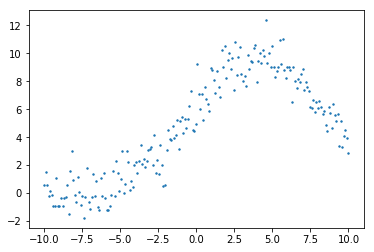

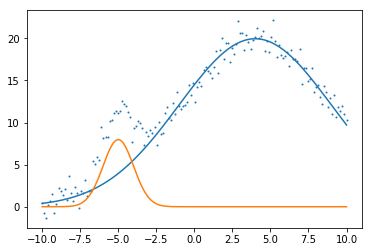

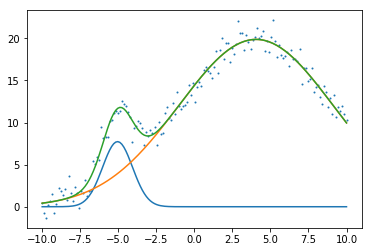

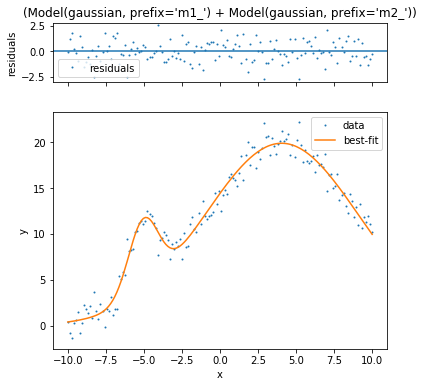

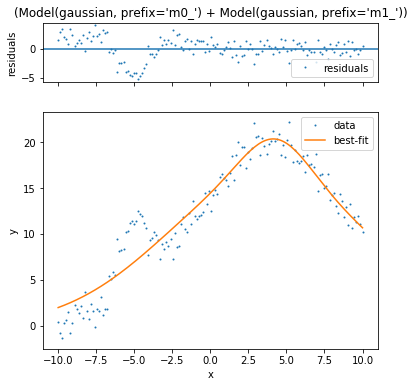